In [1]:
import pandas as pd
from data_cleaning.calc_fpoints import calc_fpoints_batter, calc_fpoints_pitcher
from data_cleaning.combine_dfs import combine_metrics_stats, pitch_combine_metrics_stats
from plotting.plots import plot_top_x_corr
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np
import pickle
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

from sklearn.feature_selection import RFE, SelectKBest, f_regression, SelectFromModel
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
import xgboost as xgb
import lightgbm as lgb
import warnings

import lime

import lime.lime_tabular
import unidecode


In [2]:
# Reading in data and calculating fantasy points
# Minimum PA of 50 for both datasets
batter_data = pd.read_csv("data/batter_base_stats.csv")
batter_fpoints = calc_fpoints_batter(batter_data, output = False)

batter_fpoints.head()

Name  year  age    K  BB  RBI   TB  SB    G   R  Fpoints  \
0   Colon, Bartolo  2015   42   24   0    4    9   0   31   2       -9   
1    Hunter, Torii  2015   39  105  35   81  213   2  139  67      293   
2     Ortiz, David  2015   39   95  77  108  292   0  146  73      455   
3  Rodriguez, Alex  2015   39  145  84   86  254   4  151  83      366   
4  Ramirez, Aramis  2015   37   68  31   75  201   1  137  43      283   

   Fpoints_G  
0  -0.290323  
1   2.107914  
2   3.116438  
3   2.423841  
4   2.065693

In [3]:
name_split = batter_fpoints['Name'].str.split(', ', expand=True)
# Combine first and last names in the desired format
# Replace accented letters in the Name column
batter_fpoints['Name'] = name_split[1] + ' ' + name_split[0]
batter_fpoints['Name'] = batter_fpoints['Name'].apply(unidecode.unidecode)

In [4]:
all_fpoints_24 = batter_fpoints[batter_fpoints['year'] == 2024][["Name", "Fpoints_G"]]
all_fpoints_24.head()

Name  Fpoints_G
4810     David Peralta   1.439560
4811  Charlie Blackmon   2.088710
4812  Martin Maldonado   0.166667
4813    Donovan Solano   1.489583
4814  Andrew McCutchen   1.900000

In [5]:
# Combining dataframes with fantasy points and metrics
batter_metrics = pd.read_csv("data/batter_metrics.csv")
batter_combined = combine_metrics_stats(batter_fpoints, batter_metrics, save=False)
batter_combined.head()

Name  Fpoints_G  year  age  k_percent  bb_percent    xba   xslg  \
0   Bartolo Colon  -0.741935  2016   43       37.5         0.0  0.153  0.169   
1     David Ortiz   3.543046  2016   40       15.5        12.5  0.301  0.616   
2  Alex Rodriguez   1.215385  2016   40       23.4        13.5  0.247  0.494   
3   Adrian Beltre   3.137255  2016   37       10.5         6.6  0.295  0.482   
4  Carlos Beltran   2.543046  2016   39       16.0         8.5  0.274  0.448   

    woba  xwoba  ...  whiff_percent  swing_percent  pull_percent  \
0  0.136  0.153  ...           30.6           58.1          20.5   
1  0.379  0.420  ...           23.2           44.7          41.9   
2  0.361  0.368  ...           32.0           43.9          38.4   
3  0.337  0.360  ...           16.8           48.1          35.3   
4  0.346  0.346  ...           18.1           45.4          40.1   

   straightaway_percent  opposite_percent  groundballs_percent  \
0                  48.7              30.8                 69.2   
1                  36.4              21.7                 37.6   
2                  43.9              16.6                 43.6   
3                  41.4              23.3                 42.4   
4                  38.3              19.3                 36.8   

   flyballs_percent  linedrives_percent  popups_percent  sprint_speed  
0               5.1                17.9             7.7          20.2  
1              25.6                28.7             8.1          23.1  
2              24.9                24.9             6.5          23.9  
3              18.4                31.6             7.6          26.4  
4              26.6                28.1             8.5          25.6  

[5 rows x 52 columns]

## EDA on batter data

In [6]:
batter_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3644 entries, 0 to 3643
Data columns (total 52 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Name                    3644 non-null   object 
 1   Fpoints_G               3644 non-null   float64
 2   year                    3644 non-null   int64  
 3   age                     3644 non-null   int64  
 4   k_percent               3644 non-null   float64
 5   bb_percent              3644 non-null   float64
 6   xba                     3644 non-null   float64
 7   xslg                    3644 non-null   float64
 8   woba                    3644 non-null   float64
 9   xwoba                   3644 non-null   float64
 10  xobp                    3644 non-null   float64
 11  xiso                    3644 non-null   float64
 12  xwobacon                3644 non-null   float64
 13  xbacon                  3644 non-null   float64
 14  avg_swing_speed         0 non-null      

In [7]:
batter_combined.isna().sum().sort_values(ascending=False)

avg_swing_speed           3644
fast_swing_rate           3644
avg_swing_length          3644
squared_up_swing          3644
squared_up_contact        3644
blasts_swing              3644
blasts_contact            3644
sprint_speed                 1
pull_percent                 0
linedrives_percent           0
avg_hyper_speed              0
z_swing_percent              0
z_swing_miss_percent         0
oz_swing_percent             0
oz_swing_miss_percent        0
oz_contact_percent           0
out_zone_percent             0
popups_percent               0
flyballs_percent             0
swing_percent                0
groundballs_percent          0
opposite_percent             0
straightaway_percent         0
hard_hit_percent             0
meatball_swing_percent       0
iz_contact_percent           0
edge_percent                 0
whiff_percent                0
avg_best_speed               0
Name                         0
poorlyweak_percent           0
poorlytopped_percent         0
year    

In [8]:
# Unfortunately all swing data is not possible to use since it was introduced in 2024. 
remove = ['avg_swing_speed',
 'fast_swing_rate',
 'blasts_contact',
 'blasts_swing',
 'squared_up_contact',
 'squared_up_swing',
 'avg_swing_length']

batter_combined = batter_combined.drop(columns = remove)
batter_combined.isna().sum()

Name                      0
Fpoints_G                 0
year                      0
age                       0
k_percent                 0
bb_percent                0
xba                       0
xslg                      0
woba                      0
xwoba                     0
xobp                      0
xiso                      0
xwobacon                  0
xbacon                    0
exit_velocity_avg         0
launch_angle_avg          0
sweet_spot_percent        0
barrel_batted_rate        0
solidcontact_percent      0
flareburner_percent       0
poorlyunder_percent       0
poorlytopped_percent      0
poorlyweak_percent        0
hard_hit_percent          0
avg_best_speed            0
avg_hyper_speed           0
z_swing_percent           0
z_swing_miss_percent      0
oz_swing_percent          0
oz_swing_miss_percent     0
oz_contact_percent        0
out_zone_percent          0
meatball_swing_percent    0
iz_contact_percent        0
edge_percent              0
whiff_percent       

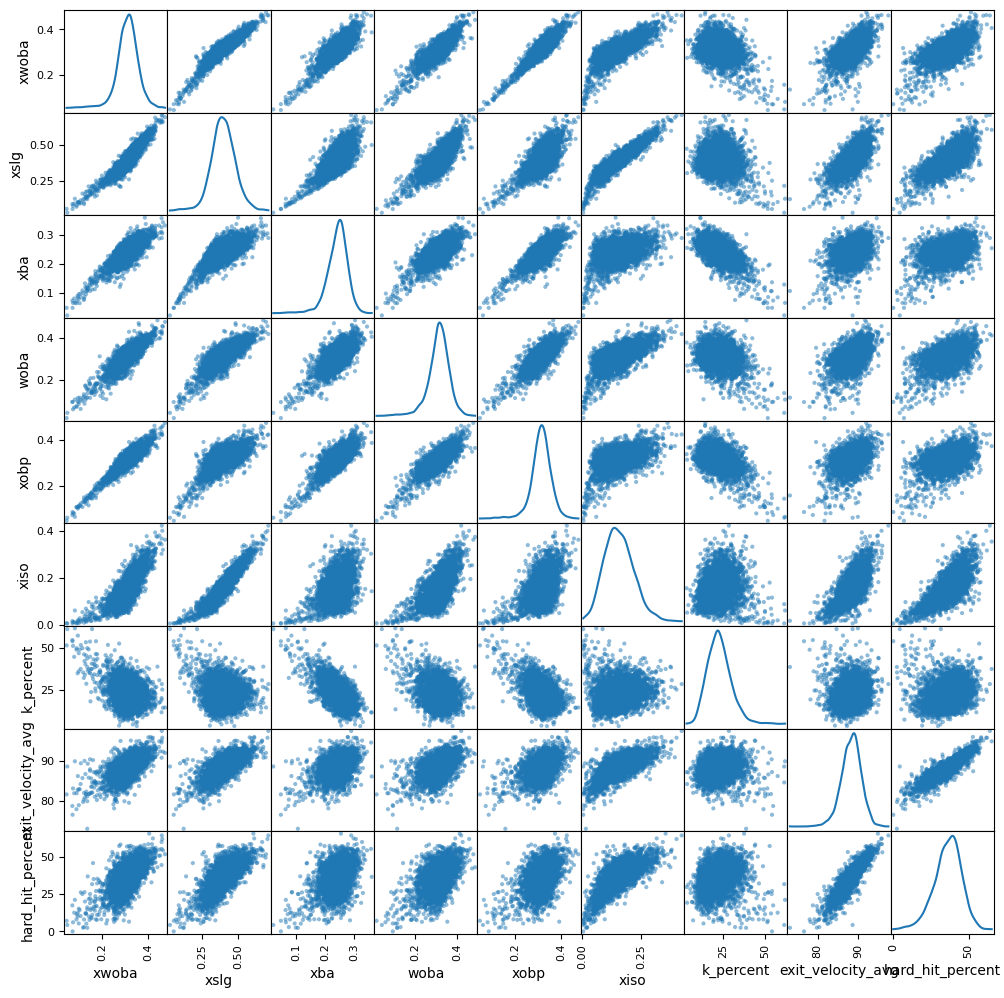

In [9]:
plot_top_x_corr(batter_combined, 10, "scatter", "Fpoints_G")

We see lots of strong correlations here - makes sense since a lot of these columns consider similar things. Also all are approx normally distributed. 

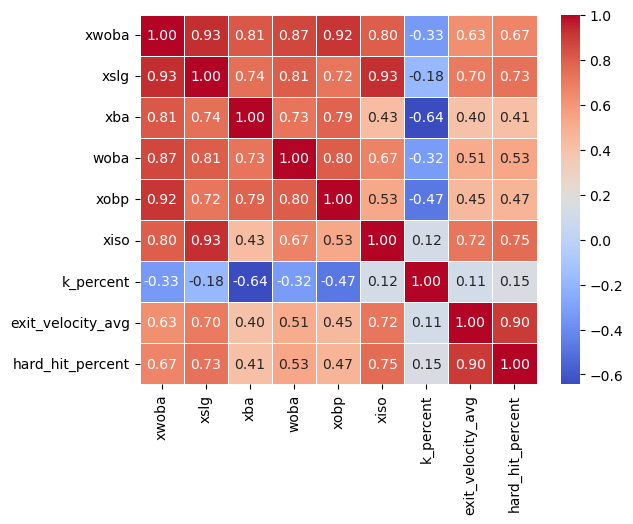

In [10]:
plot_top_x_corr(batter_combined, 10, "correlation", "Fpoints_G")



We see high correlations between many stats - as expected. K% has negative correlations also as expected. Will likely need to address this somehow with feature selection. 

In [11]:
# Adding columns that represents percentile of fpoints for the year. 
# Calculate the fantasy points from the previous year for each player
batter_combined['Fpoints_G_prev_year'] = batter_combined.groupby('Name')['Fpoints_G'].shift(1)

# Impute missing values in Fpoints_IP_prev_year using IterativeImputer
# Calculate the fantasy points from two previous years for each player
batter_combined['Fpoints_G_two_prev_year'] = batter_combined.groupby('Name')['Fpoints_G'].shift(2)

# Impute missing values in Fpoints_IP_prev_year and Fpoints_IP_two_prev_year using IterativeImputer
prev_imputer = IterativeImputer(max_iter = 30)
batter_combined[['Fpoints_G_prev_year', 'Fpoints_G_two_prev_year']] = prev_imputer.fit_transform(batter_combined[['Fpoints_G_prev_year', 'Fpoints_G_two_prev_year']])

# Calculate the weighted fantasy points for the last two years
batter_combined['Fpoints_G_weighted'] = 0.7 * batter_combined['Fpoints_G_prev_year'] + 0.3 * batter_combined['Fpoints_G_two_prev_year']

fpoints2024 = batter_combined[batter_combined['year'] == 2024][["Name", "Fpoints_G", "Fpoints_G_prev_year", "Fpoints_G_two_prev_year"]]

batter_combined['Fpoints_G_percentile'] = batter_combined.groupby('year')['Fpoints_G_prev_year'].rank(pct = True)
batter_combined = batter_combined.drop(columns = ["Fpoints_G_prev_year", "Fpoints_G_two_prev_year", "Fpoints_G_weighted"])
batter_combined["Fpoints_G_percentile"].unique().size

2508

In [12]:
batter_combined['KpBB%'] = batter_combined['k_percent'] / (batter_combined['bb_percent'] + 0.1)

## Train-test split

In [13]:
X = batter_combined.drop(columns = ['Fpoints_G'])
y = batter_combined['Fpoints_G']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)


na_ratio = X_train.isna().any(axis=1).mean()
print(f"Ratio of rows with NAs: {na_ratio:.2%}")

na_columns = X_train.columns[X_train.isna().any()].tolist()
print(f"Columns with NAs: {na_columns}")

X_train.head()

Ratio of rows with NAs: 0.03%
Columns with NAs: ['sprint_speed']


Name  year  age  k_percent  bb_percent    xba   xslg   woba  \
2780   Jose Rojas  2022   29       27.2         8.2  0.215  0.389  0.292   
2984  Jose Azocar  2023   27       20.4         5.6  0.241  0.317  0.278   
2283  Pat Valaika  2021   28       22.7         5.3  0.260  0.456  0.337   
1801  Kyle Seager  2020   32       19.4         9.9  0.258  0.487  0.332   
3007    Jose Siri  2023   27       33.2         6.2  0.207  0.323  0.268   

      xwoba   xobp  ...  pull_percent  straightaway_percent  opposite_percent  \
2780  0.293  0.283  ...          45.8                  38.1              16.1   
2984  0.272  0.285  ...          20.0                  45.0              35.0   
2283  0.323  0.300  ...          33.3                  38.0              28.7   
1801  0.350  0.339  ...          35.6                  40.5              23.9   
3007  0.261  0.262  ...          38.1                  37.1              24.7   

      groundballs_percent  flyballs_percent  linedrives_percent  \
2780                 36.4              29.7                23.7   
2984                 51.2              24.4                21.3   
2283                 35.2              29.6                27.8   
1801                 33.7              32.7                26.5   
3007                 43.3              25.8                19.6   

      popups_percent  sprint_speed  Fpoints_G_percentile     KpBB%  
2780            10.2          27.2              0.524155  3.277108  
2984             3.1          29.4              0.575650  3.578947  
2283             7.4          27.2              0.339833  4.203704  
1801             7.1          26.5              0.783379  1.940000  
3007            11.3          30.3              0.575650  5.269841  

[5 rows x 46 columns]

In [14]:


# List of columns to drop
columns_to_drop = ['Name']

# Use SimpleImputer instead of IterativeImputer
first_preprocessor = ColumnTransformer(
    transformers=[
        ('drop_columns', 'drop', columns_to_drop),
        ('impute', SimpleImputer(strategy='mean'), na_columns),
        ('passthrough_feats', 'passthrough', X_train.columns.drop(columns_to_drop).drop(na_columns))
    ]
)

# Create a pipeline with the updated preprocessor
first_pipeline = Pipeline(steps=[('preprocessor', first_preprocessor)])


# Fit the pipeline on the training data and transform both training and test data
X_train_transformed = first_pipeline.fit_transform(X_train)
X_test_transformed = first_pipeline.transform(X_test)

transformed_features = first_preprocessor.get_feature_names_out()


first_transformed_features = [col.split('__')[-1] for col in transformed_features]
X_train_transformed = pd.DataFrame(X_train_transformed, columns=first_transformed_features, index=X_train.index)
X_test_transformed = pd.DataFrame(X_test_transformed, columns=first_transformed_features, index=X_test.index)

X_train_transformed.head()

sprint_speed    year   age  k_percent  bb_percent    xba   xslg   woba  \
2780          27.2  2022.0  29.0       27.2         8.2  0.215  0.389  0.292   
2984          29.4  2023.0  27.0       20.4         5.6  0.241  0.317  0.278   
2283          27.2  2021.0  28.0       22.7         5.3  0.260  0.456  0.337   
1801          26.5  2020.0  32.0       19.4         9.9  0.258  0.487  0.332   
3007          30.3  2023.0  27.0       33.2         6.2  0.207  0.323  0.268   

      xwoba   xobp  ...  swing_percent  pull_percent  straightaway_percent  \
2780  0.293  0.283  ...           46.0          45.8                  38.1   
2984  0.272  0.285  ...           55.7          20.0                  45.0   
2283  0.323  0.300  ...           50.2          33.3                  38.0   
1801  0.350  0.339  ...           45.6          35.6                  40.5   
3007  0.261  0.262  ...           51.7          38.1                  37.1   

      opposite_percent  groundballs_percent  flyballs_percent  \
2780              16.1                 36.4              29.7   
2984              35.0                 51.2              24.4   
2283              28.7                 35.2              29.6   
1801              23.9                 33.7              32.7   
3007              24.7                 43.3              25.8   

      linedrives_percent  popups_percent  Fpoints_G_percentile     KpBB%  
2780                23.7            10.2              0.524155  3.277108  
2984                21.3             3.1              0.575650  3.578947  
2283                27.8             7.4              0.339833  4.203704  
1801                26.5             7.1              0.783379  1.940000  
3007                19.6            11.3              0.575650  5.269841  

[5 rows x 45 columns]

In [15]:
def calculate_yearly_averages(df, year_col='year'):
    # Group by year, then calculate the mean for each group
    yearly_averages = df.groupby(year_col).mean().reset_index()
    # Rename columns to indicate they are yearly averages
    yearly_averages.columns = [f"{col}_yearly_avg" if col != year_col else col for col in yearly_averages.columns]
    
    return yearly_averages

# Calculate yearly averages for the pitcher_combined dataframe
yearly_averages = calculate_yearly_averages(X_train_transformed)
yearly_averages.head()
# Merge the yearly averages with the training data
X_train_transformed_with_averages = X_train_transformed.merge(yearly_averages, on='year', how='left')

# Merge the yearly averages with the test data
X_test_transformed_with_averages = X_test_transformed.merge(yearly_averages, on='year', how='left')

# Drop year column as we dont need it anymore
X_train_transformed_with_averages = X_train_transformed_with_averages.drop(columns='year')
X_test_transformed_with_averages = X_test_transformed_with_averages.drop(columns='year')

X_train_transformed_with_averages.head()

sprint_speed   age  k_percent  bb_percent    xba   xslg   woba  xwoba  \
0          27.2  29.0       27.2         8.2  0.215  0.389  0.292  0.293   
1          29.4  27.0       20.4         5.6  0.241  0.317  0.278  0.272   
2          27.2  28.0       22.7         5.3  0.260  0.456  0.337  0.323   
3          26.5  32.0       19.4         9.9  0.258  0.487  0.332  0.350   
4          30.3  27.0       33.2         6.2  0.207  0.323  0.268  0.261   

    xobp   xiso  ...  swing_percent_yearly_avg  pull_percent_yearly_avg  \
0  0.283  0.175  ...                 47.728487                37.387240   
1  0.285  0.077  ...                 47.999709                38.326453   
2  0.300  0.196  ...                 46.023024                37.915464   
3  0.339  0.229  ...                 47.545667                37.616333   
4  0.262  0.116  ...                 47.999709                38.326453   

   straightaway_percent_yearly_avg  opposite_percent_yearly_avg  \
0                        37.437982                    25.172404   
1                        37.006105                    24.667151   
2                        37.205498                    24.883162   
3                        37.501333                    24.877667   
4                        37.006105                    24.667151   

   groundballs_percent_yearly_avg  flyballs_percent_yearly_avg  \
0                       43.900000                    25.588724   
1                       43.485756                    26.235756   
2                       44.024055                    23.995876   
3                       43.222000                    24.173333   
4                       43.485756                    26.235756   

   linedrives_percent_yearly_avg  popups_percent_yearly_avg  \
0                      23.662315                   6.847181   
1                      23.277907                   7.001163   
2                      24.804124                   7.176632   
3                      25.289667                   7.307667   
4                      23.277907                   7.001163   

   Fpoints_G_percentile_yearly_avg  KpBB%_yearly_avg  
0                         0.507702          3.308706  
1                         0.504106          3.275088  
2                         0.513712          3.160590  
3                         0.491603          3.083662  
4                         0.504106          3.275088  

[5 rows x 88 columns]

In [16]:
X_test_transformed_with_averages = X_test_transformed_with_averages.reindex(columns=X_train_transformed_with_averages.columns, fill_value=0)
X_test_transformed_with_averages.head()

sprint_speed   age  k_percent  bb_percent    xba   xslg   woba  xwoba  \
0          27.3  25.0       25.8         4.0  0.242  0.356  0.307  0.280   
1          26.7  33.0       17.5        12.7  0.210  0.329  0.315  0.298   
2          26.8  27.0       24.8         4.0  0.242  0.375  0.321  0.291   
3          28.8  26.0       24.2        11.1  0.273  0.464  0.360  0.364   
4          25.6  29.0        9.6         8.8  0.253  0.374  0.284  0.306   

    xobp   xiso  ...  swing_percent_yearly_avg  pull_percent_yearly_avg  \
0  0.277  0.114  ...                 47.292357                36.425478   
1  0.323  0.118  ...                 47.999709                38.326453   
2  0.285  0.133  ...                 47.999709                38.326453   
3  0.366  0.192  ...                 47.292357                36.425478   
4  0.325  0.121  ...                 47.545667                37.616333   

   straightaway_percent_yearly_avg  opposite_percent_yearly_avg  \
0                        37.628025                    25.553185   
1                        37.006105                    24.667151   
2                        37.006105                    24.667151   
3                        37.628025                    25.553185   
4                        37.501333                    24.877667   

   groundballs_percent_yearly_avg  flyballs_percent_yearly_avg  \
0                       47.235669                    19.632166   
1                       43.485756                    26.235756   
2                       43.485756                    26.235756   
3                       47.235669                    19.632166   
4                       43.222000                    24.173333   

   linedrives_percent_yearly_avg  popups_percent_yearly_avg  \
0                      26.285669                   6.844268   
1                      23.277907                   7.001163   
2                      23.277907                   7.001163   
3                      26.285669                   6.844268   
4                      25.289667                   7.307667   

   Fpoints_G_percentile_yearly_avg  KpBB%_yearly_avg  
0                         0.501202          5.250030  
1                         0.504106          3.275088  
2                         0.504106          3.275088  
3                         0.501202          5.250030  
4                         0.491603          3.083662  

[5 rows x 88 columns]

In [17]:
# Find columns with infinite values in X_train_transformed_with_averages
train_inf_cols = X_train_transformed_with_averages.columns.to_series()[np.isinf(X_train_transformed_with_averages).any()]

# Find columns with infinite values in X_test_transformed_with_averages
test_inf_cols = X_test_transformed_with_averages.columns.to_series()[np.isinf(X_test_transformed_with_averages).any()]

train_inf_cols, test_inf_cols

(Series([], dtype: object), Series([], dtype: object))

In [18]:
numeric_cols = X_train_transformed_with_averages.columns.tolist()

# Update the preprocessor to scale numeric features
preprocessor = ColumnTransformer(
	transformers=[
		('scale', StandardScaler(), numeric_cols)
	]
)

# Update the pipeline with the updated preprocessor
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Fit the pipeline on the training data and transform both training and test data
X_train_preprocessed = pipeline.fit_transform(X_train_transformed_with_averages)
X_test_preprocessed = pipeline.transform(X_test_transformed_with_averages)

# Convert the preprocessed data back to a DataFrame
X_train_preprocessed = pd.DataFrame(X_train_preprocessed, columns=X_train_transformed_with_averages.columns, index=X_train_transformed_with_averages.index)
X_test_preprocessed = pd.DataFrame(X_test_preprocessed, columns=X_test_transformed_with_averages.columns, index=X_test_transformed_with_averages.index)
X_train_preprocessed.shape

(2915, 88)

In [19]:
warnings.filterwarnings('ignore')



    # Update classifier_params with XGBoost and LightGBM hyperparameters
def tune_and_select_model(X_train, y_train, X_test, y_test):
    # Define feature selectors
    # feature_selectors = {
    #     'pca' : PCA(),
    #     'select_k_best': SelectKBest(score_func=f_regression, k=10),
    #     'select_from_model': SelectFromModel(estimator=RandomForestRegressor())
    # }

    # Define regressors
    regressors = {
        'linear_regression': Lasso(),
        'random_forest': RandomForestRegressor(),
        'gradient_boosting': GradientBoostingRegressor(),
        'svm': SVR(),
        'neural_network': MLPRegressor()
    }

    # Define hyperparameters for feature selectors
    # feature_selector_params = {
    #     'pca__n_components': [10, 25, 50],
    #     'select_k_best__k': [10, 25, 50],
    #     'select_from_model__max_features': [10, 25, 50]
    # }

    # Define hyperparameters for regressors
    regressor_params = {
        'linear_regression__alpha': np.logspace(-4, 2, 50),
        'random_forest__n_estimators': [25, 50, 100, 200],
        'random_forest__max_depth': [2,4,6,10,14,18,25,40],
        'gradient_boosting__n_estimators': [50, 100, 200],
        'svm__C': [0.01, 0.1, 1, 10],
        'neural_network__hidden_layer_sizes': [(50,), (100,), (50, 50)]
    }

    # Create a list to store the results
    results = []

    # Iterate over feature selectors and regressors

    # Add XGBoost and LightGBM to regressors
    regressors.update({
        'xgboost': xgb.XGBRegressor(),
        'lightgbm': lgb.LGBMRegressor(verbose = -1)
    })

    # Update regressor_params with XGBoost and LightGBM hyperparameters
    regressor_params.update({
        'xgboost__n_estimators': [25,50, 100, 200],
        'xgboost__learning_rate': [0.001,0.01, 0.1, 0.2],
        'lightgbm__n_estimators': [25,50, 100, 200],
        'lightgbm__learning_rate': [0.001,0.01, 0.1, 0.2]
    })

    # for fs_name, fs in feature_selectors.items():
    for reg_name, reg in regressors.items():
        # Create a pipeline
        pipeline = Pipeline([
            # (fs_name, fs),
            (reg_name, reg)
        ])

        # Combine hyperparameters
        # params = {**{f'{k}': v for k, v in feature_selector_params.items() if k.startswith(fs_name)},
                    # **{f'{k}': v for k, v in regressor_params.items() if k.startswith(reg_name)}}

        params = {**{f'{k}': v for k, v in regressor_params.items() if k.startswith(reg_name)}}
        
        print(f' Searching {params}')

        # Perform RandomizedSearchCV
        search = RandomizedSearchCV(pipeline, param_distributions=params, n_iter=5, cv=3, random_state=42)
        print("Search complete")
        search.fit(X_train, y_train)
        print("Fit complete")

        # Get the best model
        best_model = search.best_estimator_

        # Make predictions
        y_pred = best_model.predict(X_test)

        # Calculate metrics
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)

        print("results calculated")

        # Store the results
        results.append({
            # 'feature_selector': fs_name,
            'regressor': reg_name,
            'best_params': search.best_params_,
            'mse': mse,
            'rmse': rmse
        })

    # Find the best result
    best_result = min(results, key=lambda x: x['rmse'])

    return best_result, results



# Example usage
# best_result, all_results = tune_and_select_model(X_train_preprocessed, y_train, X_test_preprocessed, y_test)
# print("Best Result:", best_result)
# print("All Results:", all_results)

In [20]:
# with open('models/batter_model_feb16_best.pkl', 'wb') as f:
#     pickle.dump(best_result, f)

In [21]:
## Same as pitch: 0.33 MSE
with open('models/batter_model_feb16_best.pkl', 'rb') as f:
    loaded_best_result = pickle.load(f)

loaded_best_result

{'regressor': 'gradient_boosting',
 'best_params': {'gradient_boosting__n_estimators': 100},
 'mse': 0.33389427869480365,
 'rmse': np.float64(0.577835857917111)}

In [22]:
# Extract the best feature selector, regressor, and parameters
# best_feature_selector_name = loaded_best_result['feature_selector']
best_regressor_name = loaded_best_result['regressor']
best_params = loaded_best_result['best_params']

# Define feature selectors
# feature_selectors = {
#     'pca': PCA(),
#     'select_k_best': SelectKBest(score_func=f_regression),
#     'select_from_model': SelectFromModel(estimator=RandomForestRegressor())
# }

# Define regressors
regressors = {
    'linear_regression': Lasso(),
    'random_forest': RandomForestRegressor(),
    'gradient_boosting': GradientBoostingRegressor(),
    'svm': SVR(),
    'neural_network': MLPRegressor(),
    'xgboost': xgb.XGBRegressor(),
    'lightgbm': lgb.LGBMRegressor()
}

# Create the pipeline with the best feature selector and regressor
best_model = Pipeline([
    # (best_feature_selector_name, feature_selectors[best_feature_selector_name]),
    (best_regressor_name, regressors[best_regressor_name])
])

# Set the best parameters
best_model.set_params(**best_params)
best_model.fit(X_train_preprocessed, y_train)

Pipeline(steps=[('gradient_boosting', GradientBoostingRegressor())])

In [23]:
# Extract the feature importances from the best model
if hasattr(best_model.named_steps[best_regressor_name], 'feature_importances_'):
    importances = best_model.named_steps[best_regressor_name].feature_importances_
elif hasattr(best_model.named_steps[best_regressor_name], 'coef_'):
    importances = best_model.named_steps[best_regressor_name].coef_
else:
    raise ValueError(f"The model {best_regressor_name} does not have feature importances or coefficients.")

# Create a DataFrame for the feature importances
feature_importances_df = pd.DataFrame({
    'Feature': X_train_preprocessed.columns,
    'Importance': importances
})

# Sort the DataFrame by importance
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

feature_importances_df.head(10)  # Display the top 10 features
# feature_importances_df.to_csv("data/batter_feature_importances.csv", index=False)

Feature  Importance
42  Fpoints_G_percentile    0.423210
7                  xwoba    0.082663
4                    xba    0.062977
5                   xslg    0.051417
28    oz_contact_percent    0.037209
8                   xobp    0.033164
1                    age    0.025769
0           sprint_speed    0.021904
22        avg_best_speed    0.014953
12     exit_velocity_avg    0.014465

In [24]:

# Extract the gradient boosting model from the best_model pipeline
gradient_boosting_model = best_model.named_steps['gradient_boosting']

# Create a LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_preprocessed.values,
    feature_names=X_train_preprocessed.columns,
    class_names=['Fpoints_IP'],
    mode='regression'
)

# Select an instance to explain
instance_idx = 90
instance = X_test_preprocessed.iloc[instance_idx].values.reshape(1, -1)

# Generate explanation
explanation = explainer.explain_instance(
    data_row=instance[0],
    predict_fn=gradient_boosting_model.predict
)
# Get the name corresponding to the instance being explained
instance_name = X_test.iloc[instance_idx]['Name']
print(f"Explaining prediction for: {instance_name}")

# Show the explanation
explanation.show_in_notebook(show_table=True)

Explaining prediction for: Logan Morrison


In [25]:
# all_results = pd.DataFrame(all_results).sort_values(by = 'mse')
# all_results

In [26]:
razz_preds = pd.read_csv("data/razzball_batting.csv")
razz_preds.head()
print(razz_preds.columns)

Index(['#', 'Name', 'Team', 'Bats', 'ESPN', 'YAHOO', 'G', 'PA', 'AB', 'R',
       'HR', 'RBI', 'SB', 'H', '1B', '2B', '3B', 'TB', 'SO', 'BB', 'HBP', 'SF',
       'SH', 'CS', 'AVG', 'OBP', 'SLG', 'OPS', 'BABIP', 'RazzID'],
      dtype='object')


In [27]:
# razz_preds['Name'] = razz_preds['Name'].str.replace(r"`", "a")
names_2025 = razz_preds['Name'].unique()
razz_preds.head(20)
razz_preds[razz_preds['Name'].str.contains('Rooker')]

#          Name Team Bats ESPN YAHOO    G   PA   AB     R  ...  HBP   SF  \
29  30  Brent Rooker  ATH    R   DH    OF  150  623  549  83.3  ...  8.2  4.2   

     SH   CS    AVG    OBP   SLG    OPS  BABIP  RazzID  
29  1.4  2.2  0.238  0.319  0.45  0.768  0.302  667670  

[1 rows x 30 columns]

In [28]:
all_fpoints_24[all_fpoints_24['Name'].str.contains('Yandy')]

Name  Fpoints_G
5002  Yandy Diaz   2.124138

In [29]:
razz_preds[razz_preds['Name'] == "Yandy Diaz"]

#        Name Team Bats ESPN YAHOO    G   PA   AB     R  ...  HBP   SF  \
93  94  Yandy Diaz   TB    R   1B    1B  135  564  496  73.2  ...  5.6  3.3   

     SH   CS    AVG    OBP    SLG    OPS  BABIP  RazzID  
93  2.5  0.6  0.284  0.361  0.431  0.792  0.317  650490  

[1 rows x 30 columns]

In [30]:
# Find names in names_2025 that aren't in all_fpoints_24['Name']
missing_names = [name for name in names_2025 if name not in all_fpoints_24['Name'].values]
missing_names

['Brent Rooker',
 'George Springer',
 'Matt McLain',
 'TJ Friedl',
 'Cedric Mullins',
 'Colson Montgomery',
 'Jacob Wilson',
 'Matt Shaw',
 'MJ Melendez',
 'Yoan Moncada',
 'Deyvison De Los Santos',
 'Hyeseong Kim',
 'Oswald Peraza',
 'Brady House',
 'Tirso Ornelas',
 'Juan Brito',
 'Caleb Durbin',
 'Josh H. Smith',
 'Taylor Trammell',
 'Endy Rodriguez',
 'Roman Anthony',
 'Jordan Lawlar',
 'Cole Young',
 'Orelvis Martinez',
 'Agustin Ramirez',
 'Matt Mervis',
 'Jake Mangum',
 'Tyler Locklear',
 'Graham Pauley',
 'Tyler Heineman',
 'Tom Murphy',
 'Chase DeLauter',
 'Joey Wiemer',
 'Alexander Canario',
 'Travis Bazzana',
 'Yuli Gurriel',
 'Carlos Narvaez',
 'Javier Sanoja',
 'Billy Cook',
 'Luisangel Acuna',
 'Liam Hicks',
 'Nick Yorke',
 'Brock Wilken',
 'Jacob Melton',
 'Kristian Campbell',
 'Gage Workman',
 'Drake Baldwin',
 'Coby Mayo',
 'Matt Duffy',
 'Brandon Lockridge',
 'Joey Wendle',
 'Trey Lipscomb',
 'Chase Meidroth',
 'Aledmys Diaz',
 'Oscar Colas',
 'Marcelo Mayer',
 'Chris

In [31]:
import re

# Define a list of common suffixes
suffixes = ['Jr.', 'Sr.', 'II', 'III', 'IV', 'V']

# Function to remove suffix from a name
def remove_suffix(name):
    for suffix in suffixes:
        if name.endswith(suffix):
            return name.replace(suffix, '').strip()
    return name

# Iterate through missing_names and check against all_fpoints_24 names
updated_missing_names = []
for name in missing_names:
    found = False
    for fpoints_name in all_fpoints_24['Name']:
        if remove_suffix(fpoints_name) == name:
            found = True
            break
    if not found:
        updated_missing_names.append(name)

updated_missing_names
for i, name in enumerate(updated_missing_names):
    for suffix in suffixes:
        if name + ' ' + suffix in all_fpoints_24['Name'].values:
            updated_missing_names[i] = name + ' ' + suffix
            break

updated_missing_names

['George Springer III',
 'Matt McLain',
 'Colson Montgomery',
 'Matt Shaw',
 'Yoan Moncada',
 'Deyvison De Los Santos',
 'Hyeseong Kim',
 'Oswald Peraza',
 'Brady House',
 'Tirso Ornelas',
 'Juan Brito',
 'Caleb Durbin',
 'Josh H. Smith',
 'Taylor Trammell',
 'Endy Rodriguez',
 'Roman Anthony',
 'Jordan Lawlar',
 'Cole Young',
 'Orelvis Martinez',
 'Agustin Ramirez',
 'Matt Mervis',
 'Jake Mangum',
 'Tyler Locklear',
 'Graham Pauley',
 'Tyler Heineman',
 'Tom Murphy',
 'Chase DeLauter',
 'Joey Wiemer',
 'Alexander Canario',
 'Travis Bazzana',
 'Carlos Narvaez',
 'Javier Sanoja',
 'Billy Cook',
 'Luisangel Acuna',
 'Liam Hicks',
 'Nick Yorke',
 'Brock Wilken',
 'Jacob Melton',
 'Kristian Campbell',
 'Gage Workman',
 'Drake Baldwin',
 'Coby Mayo',
 'Matt Duffy',
 'Brandon Lockridge',
 'Joey Wendle',
 'Trey Lipscomb III',
 'Chase Meidroth',
 'Aledmys Diaz',
 'Oscar Colas',
 'Marcelo Mayer',
 'Christian Moore',
 'Shay Whitcomb',
 'Luke Keaschall',
 'Cooper Bowman',
 'Pedro Leon',
 'Greg Jo

In [32]:
batter_mets = pd.read_csv("data/batter_metrics.csv")
batter_mets= batter_mets.rename(columns={"last_name, first_name": "Name"})
name_split = batter_mets['Name'].str.split(', ', expand=True)

# Combine first and last names in the desired format
batter_mets['Name'] = name_split[1] + ' ' + name_split[0]
batter_mets['Name'] = batter_mets['Name'].apply(unidecode.unidecode)
batter_mets.head()

Name  player_id  year  k_percent  bb_percent    xba   xslg  \
0   Bartolo Colon     112526  2015       37.5         0.0  0.153  0.169   
1    Torii Hunter     116338  2015       18.5         6.2  0.229  0.370   
2     David Ortiz     120074  2015       15.5        12.5  0.301  0.616   
3  Alex Rodriguez     121347  2015       23.4        13.5  0.247  0.494   
4  Aramis Ramirez     133380  2015       13.2         6.0  0.240  0.405   

    woba  xwoba   xobp  ...  whiff_percent  swing_percent  pull_percent  \
0  0.136  0.153  0.167  ...           30.6           58.1          20.5   
1  0.304  0.290  0.285  ...           23.1           53.4          34.7   
2  0.379  0.420  0.388  ...           23.2           44.7          41.9   
3  0.361  0.368  0.355  ...           32.0           43.9          38.4   
4  0.309  0.304  0.293  ...           17.9           52.9          36.9   

   straightaway_percent  opposite_percent  groundballs_percent  \
0                  48.7              30.8                 69.2   
1                  40.4              24.2                 49.4   
2                  36.4              21.7                 37.6   
3                  43.9              16.6                 43.6   
4                  38.3              24.8                 37.6   

   flyballs_percent  linedrives_percent  popups_percent  sprint_speed  
0               5.1                17.9             7.7          20.2  
1              22.6                20.9             7.1          26.5  
2              25.6                28.7             8.1          23.1  
3              24.9                24.9             6.5          23.9  
4              24.5                29.1             8.7          24.3  

[5 rows x 51 columns]

In [33]:
all_fpoints_24.shape

(526, 2)

In [34]:
# Iterate through names in names_2025
for name in updated_missing_names:
        # Get the most recent data from pitcher_fpoints for the name
        recent_data = batter_fpoints[batter_fpoints['Name'] == name].sort_values(by='year', ascending=False).head(1).copy()
        # print(f'{name}: {recent_data}')
        recent_data.loc[:, 'year'] = 2024

        print(f'name: {name}, recent_data: {recent_data}')

        recent_metrics = batter_mets[batter_mets['Name'] == name].sort_values(by='year', ascending=False).head(1).copy()
        recent_metrics.loc[:, 'year'] = 2024

        # print(recent_data)
        
        # Check if there is any data for the name
        if not recent_data.empty:
            # Append the most recent data to all_fpoints_24
            all_fpoints_24 = pd.concat([all_fpoints_24, recent_data[['Name', 'Fpoints_G']]], ignore_index=True)
            batter_mets = pd.concat([batter_mets, recent_metrics], ignore_index=True)

all_fpoints_24[all_fpoints_24['Name'].str.contains("Diaz")]

name: George Springer III, recent_data:                      Name  year  age    K  BB  RBI   TB  SB    G   R  Fpoints  \
4845  George Springer III  2024   34  115  60   56  202  16  145  74      293   

      Fpoints_G  
4845    2.02069  
name: Matt McLain, recent_data:              Name  year  age    K  BB  RBI   TB  SB   G   R  Fpoints  \
4753  Matt McLain  2024   23  115  31   50  185  14  89  65      230   

      Fpoints_G  
4753    2.58427  
name: Colson Montgomery, recent_data: Empty DataFrame
Columns: [Name, year, age, K, BB, RBI, TB, SB, G, R, Fpoints, Fpoints_G]
Index: []
name: Matt Shaw, recent_data: Empty DataFrame
Columns: [Name, year, age, K, BB, RBI, TB, SB, G, R, Fpoints, Fpoints_G]
Index: []
name: Yoan Moncada, recent_data:               Name  year  age    K  BB  RBI   TB  SB   G   R  Fpoints  \
4547  Yoan Moncada  2024   28  107  20   40  142   1  92  39      135   

      Fpoints_G  
4547   1.467391  
name: Deyvison De Los Santos, recent_data: Empty DataFrame
Columns

Name  Fpoints_G
42     Elias Diaz   1.468750
192    Yandy Diaz   2.124138
385   Yainer Diaz   2.236486
538  Aledmys Diaz   0.981651

In [35]:
fpoints2024[fpoints2024['Name'].str.contains("Diaz")]

Name  Fpoints_G  Fpoints_G_prev_year  Fpoints_G_two_prev_year
3266   Elias Diaz   1.468750             1.673759                 1.447619
3405   Yandy Diaz   2.124138             3.051095                 2.547445
3564  Yainer Diaz   2.236486             1.822928                 1.882943

In [36]:
fpoints2024 = fpoints2024.merge(all_fpoints_24, on = ["Name", "Fpoints_G"], how = "outer")
fpoints2024.head()

Name  Fpoints_G  Fpoints_G_prev_year  Fpoints_G_two_prev_year
0   Aaron Hicks   0.277778             1.741935                 1.361538
1   Aaron Judge   3.987342             3.207547                 3.866242
2  Aaron Schunk   0.641026                  NaN                      NaN
3  Abraham Toro   1.489362                  NaN                      NaN
4   Adam Duvall   0.759615             2.054348                 1.279070

In [37]:
fpoints2024[fpoints2024['Name'].str.contains("Matt")]

Name  Fpoints_G  Fpoints_G_prev_year  Fpoints_G_two_prev_year
368  Matt Carpenter   0.762712             1.105263                 3.021277
369    Matt Chapman   2.357143             1.692857                 1.883871
370      Matt Duffy   0.884615                  NaN                      NaN
371     Matt McLain   2.584270                  NaN                      NaN
372     Matt Mervis   0.777778                  NaN                      NaN
373      Matt Olson   2.166667             3.524691                 2.395062
374     Matt Thaiss   0.877193             1.126316                 1.444856
375   Matt Vierling   1.958333             1.723881                 1.256410
376    Matt Wallner   1.466667             1.855263                 1.903278

In [38]:
## Prediciting for 2025
batter_mets_2024 = batter_mets[batter_mets['year'] == 2024]
batter_mets_2024["KpBB%"] = batter_mets_2024["k_percent"] - batter_mets_2024["bb_percent"]
batter_2024 = batter_mets_2024.merge(fpoints2024, on="Name")
batter_2024[batter_2024['Name'].str.contains("Diaz")]

Name  player_id  year  k_percent  bb_percent    xba   xslg  \
43     Elias Diaz     553869  2024       19.7         5.7  0.242  0.343   
193    Yandy Diaz     650490  2024       15.3         8.1  0.277  0.423   
386   Yainer Diaz     673237  2024       17.3         3.9  0.299  0.458   
542  Aledmys Diaz     649557  2024       19.2         4.9  0.235  0.327   

      woba  xwoba   xobp  ...  opposite_percent  groundballs_percent  \
43   0.303  0.280  0.293  ...              22.1                 51.2   
193  0.331  0.336  0.340  ...              30.5                 55.5   
386  0.329  0.339  0.327  ...              21.2                 51.2   
542  0.268  0.271  0.288  ...              22.8                 47.2   

     flyballs_percent  linedrives_percent  popups_percent  sprint_speed  \
43               17.1                25.6             6.2          24.4   
193              17.8                21.2             5.5          25.4   
386              18.7                25.5             4.5          27.1   
542              18.1                25.2             9.4          26.0   

     KpBB%  Fpoints_G  Fpoints_G_prev_year  Fpoints_G_two_prev_year  
43    14.0   1.468750             1.673759                 1.447619  
193    7.2   2.124138             3.051095                 2.547445  
386   13.4   2.236486             1.822928                 1.882943  
542   14.3   0.981651                  NaN                      NaN  

[4 rows x 55 columns]

In [39]:

# Impute missing values in Fpoints_IP_prev_year and Fpoints_IP_two_prev_year using IterativeImputer
batter_2024[['Fpoints_G_prev_year', 'Fpoints_G_two_prev_year']] = prev_imputer.transform(batter_2024[['Fpoints_G_prev_year', 'Fpoints_G_two_prev_year']])

# Calculate the weighted fantasy points for the last two years
batter_2024['Fpoints_G_weighted'] = 0.7 * batter_2024['Fpoints_G_prev_year'] + 0.3 * batter_2024['Fpoints_G_two_prev_year']

# Calculate the percentile of the weighted fantasy points for each year
batter_2024['Fpoints_G_percentile'] = batter_2024.groupby('year')['Fpoints_G_weighted'].rank(pct=True).drop(columns = ["Fpoints_G_prev_year", "Fpoints_G_two_prev_year", "Fpoints_G_weighted"])

print(batter_2024['Fpoints_G_prev_year'].unique().size)
batter_2024.head()

batter_2024[batter_2024['Name'].str.contains("Diaz")]

334


Name  player_id  year  k_percent  bb_percent    xba   xslg  \
43     Elias Diaz     553869  2024       19.7         5.7  0.242  0.343   
193    Yandy Diaz     650490  2024       15.3         8.1  0.277  0.423   
386   Yainer Diaz     673237  2024       17.3         3.9  0.299  0.458   
542  Aledmys Diaz     649557  2024       19.2         4.9  0.235  0.327   

      woba  xwoba   xobp  ...  flyballs_percent  linedrives_percent  \
43   0.303  0.280  0.293  ...              17.1                25.6   
193  0.331  0.336  0.340  ...              17.8                21.2   
386  0.329  0.339  0.327  ...              18.7                25.5   
542  0.268  0.271  0.288  ...              18.1                25.2   

     popups_percent  sprint_speed  KpBB%  Fpoints_G  Fpoints_G_prev_year  \
43              6.2          24.4   14.0   1.468750             1.673759   
193             5.5          25.4    7.2   2.124138             3.051095   
386             4.5          27.1   13.4   2.236486             1.822928   
542             9.4          26.0   14.3   0.981651             1.822928   

     Fpoints_G_two_prev_year  Fpoints_G_weighted  Fpoints_G_percentile  
43                  1.447619            1.605917              0.237847  
193                 2.547445            2.900000              0.972222  
386                 1.882943            1.840932              0.515625  
542                 1.882943            1.840932              0.515625  

[4 rows x 57 columns]

In [40]:
age_2024 = pd.read_csv("data/batter_2024_age.csv")

age_2024 = age_2024.rename(columns = {"last_name, first_name":"Name", "player_age":"age"})

name_split = age_2024['Name'].str.split(', ', expand=True)

# Combine first and last names in the desired format
age_2024['Name'] = name_split[1] + ' ' + name_split[0]

age_2024['Name'] = age_2024['Name'].apply(unidecode.unidecode)

batter_mets_2024_new = batter_2024.merge(age_2024, on = ["Name", 'year', 'player_id'], how = 'left').drop(columns = ['player_id'])

batter_mets_2024_new = batter_mets_2024_new.fillna(30)

batter_mets_2024_new[batter_mets_2024_new['Name'].str.contains("Diaz")]

Name  year  k_percent  bb_percent    xba   xslg   woba  xwoba  \
43     Elias Diaz  2024       19.7         5.7  0.242  0.343  0.303  0.280   
193    Yandy Diaz  2024       15.3         8.1  0.277  0.423  0.331  0.336   
386   Yainer Diaz  2024       17.3         3.9  0.299  0.458  0.329  0.339   
542  Aledmys Diaz  2024       19.2         4.9  0.235  0.327  0.268  0.271   

      xobp   xiso  ...  linedrives_percent  popups_percent  sprint_speed  \
43   0.293  0.101  ...                25.6             6.2          24.4   
193  0.340  0.146  ...                21.2             5.5          25.4   
386  0.327  0.159  ...                25.5             4.5          27.1   
542  0.288  0.092  ...                25.2             9.4          26.0   

     KpBB%  Fpoints_G  Fpoints_G_prev_year  Fpoints_G_two_prev_year  \
43    14.0   1.468750             1.673759                 1.447619   
193    7.2   2.124138             3.051095                 2.547445   
386   13.4   2.236486             1.822928                 1.882943   
542   14.3   0.981651             1.822928                 1.882943   

     Fpoints_G_weighted  Fpoints_G_percentile   age  
43             1.605917              0.237847  33.0  
193            2.900000              0.972222  32.0  
386            1.840932              0.515625  25.0  
542            1.840932              0.515625  30.0  

[4 rows x 57 columns]

In [41]:
import warnings

warnings.filterwarnings('ignore')


# Imputation processing
new_preprocessed_first = first_pipeline.transform(batter_mets_2024_new)
new_preprocessed_first = pd.DataFrame(new_preprocessed_first, columns=first_transformed_features, index=batter_mets_2024_new.index)

# Calculate yearly averages for the pitcher_combined dataframe
yearly_averages_new = calculate_yearly_averages(new_preprocessed_first)

# Merge the yearly averages with the training data
yearly_new_prep = new_preprocessed_first.merge(yearly_averages_new, on='year', how='left')

# Drop year column as we dont need it anymore
yearly_new_prep = yearly_new_prep.drop(columns='year')

# print(yearly_new_prep["fastball_avg_break_z_induced"])


# Generate feature combinations

# Reindex to match the training data columns

# print(yearly_new_prep)
new_transformed = pipeline.transform(yearly_new_prep)
print(new_transformed.shape)
new_transformed = pd.DataFrame(new_transformed, columns=numeric_cols, index=yearly_new_prep.index)

# expected_columns = pd.Index(selector.get_feature_names_out())  # or use the columns from the fitting data

# new_selected = new_transformed.reindex(columns=expected_columns, fill_value=0)
# new_selected = pd.DataFrame(new_selected, columns=selected_features, index=new_transformed.index)
# 
# print(new_selected.isna().sum())
# Find the columns that are different between new_transformed and X_train_preprocessed
diff_columns = set(new_transformed.columns).difference(set(X_train_preprocessed.columns))
print(f"Columns in new_transformed but not in X_train_preprocessed: {diff_columns}")

new_preds = best_model.predict(new_transformed)

(576, 88)
Columns in new_transformed but not in X_train_preprocessed: set()


In [42]:
## Combining preds with data:
batter_2024['proj_fpoints_g'] = new_preds
batter_2024[['Name', 'proj_fpoints_g']].sort_values(by = 'proj_fpoints_g', ascending = False).head(50)

Name  proj_fpoints_g
220          Shohei Ohtani        3.344405
275              Juan Soto        3.278362
418         Bobby Witt Jr.        3.166273
67             Aaron Judge        3.149437
363         Yordan Alvarez        3.136691
109           Jose Ramirez        3.067226
241            Kyle Tucker        2.963769
96            Mookie Betts        2.937907
521        Jackson Merrill        2.801602
222       Ronald Acuna Jr.        2.797358
84        Francisco Lindor        2.796931
271     Fernando Tatis Jr.        2.765971
110           Alex Bregman        2.756020
113           Corey Seager        2.712839
15         Freddie Freeman        2.709873
272  Vladimir Guerrero Jr.        2.692851
185          Rafael Devers        2.654589
189            Luis Arraez        2.647043
193             Yandy Diaz        2.636105
412        Julio Rodriguez        2.596784
41            Bryce Harper        2.578156
186            Josh Naylor        2.562725
40              Mike Trout        2.546398
180           Ozzie Albies        2.540925
236           Austin Riley        2.536650
131             Matt Olson        2.533584
463         Corbin Carroll        2.528137
68           Manny Machado        2.513005
261              Alec Bohm        2.512559
435            Steven Kwan        2.502957
137            Pete Alonso        2.495342
103            Ketel Marte        2.470596
151         Cody Bellinger        2.458180
12             Jose Altuve        2.428058
234           Nico Hoerner        2.424512
464       Gunnar Henderson        2.413475
25           Marcell Ozuna        2.374527
318         Bryan Reynolds        2.373555
136      Anthony Santander        2.366572
34           Marcus Semien        2.344235
373      Michael Harris II        2.343608
105          Brandon Nimmo        2.334026
228      William Contreras        2.333628
473     Vinnie Pasquantino        2.327927
342             Will Smith        2.321771
497       Tyler Soderstrom        2.318453
326        Adley Rutschman        2.313629
106            Trea Turner        2.305445
73        Christian Yelich        2.300181
11        Paul Goldschmidt        2.299223

Explaining prediction for: Jazz Chisholm Jr.


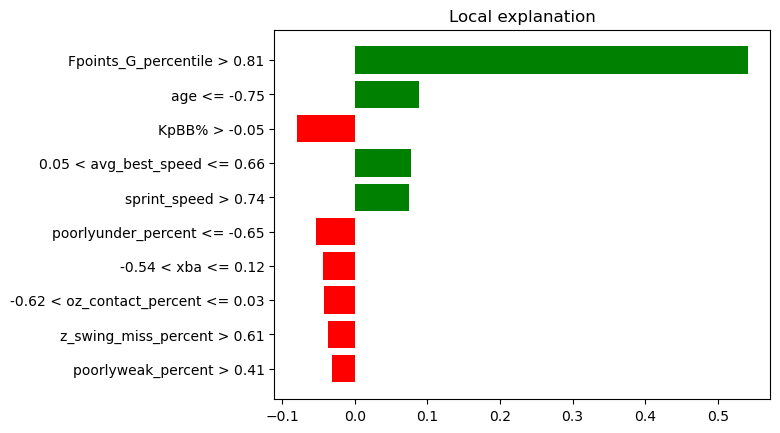

In [50]:
# Get the index based on a name input
input_name = "Jazz Chisholm Jr."
instance_idx = batter_mets_2024_new[batter_mets_2024_new['Name'] == input_name].index[0]
instance = new_transformed.iloc[instance_idx].values.reshape(1, -1)

# Generate explanation
explanation = explainer.explain_instance(
    data_row=instance[0],
    predict_fn=gradient_boosting_model.predict
)

# Get the name corresponding to the instance being explained
instance_name = batter_mets_2024_new.iloc[instance_idx]['Name']
print(f"Explaining prediction for: {instance_name}")

# Show the explanation with larger plot settings
explanation.show_in_notebook(show_table=True)
# explanation.show_in_notebook(show_table=True)

new_name = input_name.replace(" ", "_")
fig = explanation.as_pyplot_figure()

fig.savefig(f"mlb-book/figures/{new_name}_explanation.png", dpi = 300, bbox_inches = 'tight')

In [44]:
whole_df = batter_2024.merge(razz_preds, on = "Name", how = "left")
whole_df['proj_fpoints'] = whole_df['proj_fpoints_g'] * whole_df['G']
# whole_df['proj_fpoints'] = whole_df['proj_fpoints_skill'] + 2*whole_df['W'] - 2*whole_df['L'] + 5*whole_df['SV'] + 2*whole_df["HLD"]
final_df=whole_df[["Name", "ESPN", "proj_fpoints"]].sort_values(by = "proj_fpoints", ascending = False)
final_df["rank"] = final_df["proj_fpoints"].rank(ascending = False)
final_df=final_df.set_index("rank")
final_df = final_df.rename(columns = {"ESPN":"Pos"})
final_df.head(50)




Name    Pos  proj_fpoints
rank                                            
1.0           Shohei Ohtani     DH    501.660719
2.0               Juan Soto     OF    495.032689
3.0          Bobby Witt Jr.     SS    478.107152
4.0            Jose Ramirez     3B    460.083944
5.0             Aaron Judge     OF    456.668307
6.0          Yordan Alvarez     OF    439.136671
7.0             Kyle Tucker     OF    426.782738
8.0         Jackson Merrill     OF    425.843568
9.0            Mookie Betts  SS/OF    423.058672
10.0       Francisco Lindor     SS    419.539635
11.0           Alex Bregman     3B    413.402947
12.0  Vladimir Guerrero Jr.     1B    406.620444
13.0        Freddie Freeman     1B    406.480902
14.0            Luis Arraez  1B/2B    399.703487
15.0          Rafael Devers     3B    398.188360
16.0     Fernando Tatis Jr.     OF    390.001892
17.0        Julio Rodriguez     OF    389.517566
18.0             Matt Olson     1B    380.037574
19.0            Josh Naylor     1B    379.283340
20.0            Pete Alonso     1B    374.301348
21.0         Corbin Carroll     OF    374.164341
22.0           Bryce Harper     1B    373.832609
23.0          Manny Machado     3B    371.924699
24.0              Alec Bohm     3B    371.858765
25.0           Austin Riley     3B    367.814242
26.0           Ozzie Albies     2B    365.893190
27.0            Ketel Marte     2B    365.648214
28.0       Gunnar Henderson     SS    364.434676
29.0            Steven Kwan     OF    357.922841
30.0          Marcell Ozuna     DH    356.178997
31.0         Bryan Reynolds     OF    356.033205
32.0             Yandy Diaz     1B    355.874173
33.0           Corey Seager     SS    352.669033
34.0            Jose Altuve     2B    352.068478
35.0          Marcus Semien     2B    351.635271
36.0        Jackson Chourio     OF    344.409201
37.0           Nico Hoerner     2B    344.280751
38.0       Paul Goldschmidt     1B    340.285060
39.0         Cody Bellinger  1B/OF    339.228849
40.0      Michael Harris II     OF    337.479547
41.0        Elly De La Cruz     SS    336.444869
42.0      Anthony Santander     OF    336.053266
43.0     Vinnie Pasquantino     1B    335.221507
44.0         Wyatt Langford     OF    333.835009
45.0            Trea Turner     SS    331.984143
46.0          Brandon Nimmo     OF    331.431747
47.0      William Contreras      C    329.041591
48.0               Ian Happ     OF    327.787508
49.0        Adley Rutschman      C    326.221632
50.0        Randy Arozarena     OF    324.015720

In [45]:
# final_df.to_csv("predictions/initial_batter_preds.csv")

In [46]:
pitcher_preds = pd.read_csv("predictions/initial_picher_preds.csv")
all_df = pd.concat([pitcher_preds, final_df], ignore_index = True)
all_df = all_df[["Name", "Pos", "proj_fpoints"]].sort_values(by = "proj_fpoints", ascending = False)
all_df["Rank"] = all_df["proj_fpoints"].rank(ascending = False)
all_df = all_df.set_index("Rank")
# all_df.to_csv("predictions/initial_all_preds.csv")
all_df.head(50)

Name    Pos  proj_fpoints
Rank                                            
1.0           Shohei Ohtani     DH    501.660719
2.0               Juan Soto     OF    495.032689
3.0            Zack Wheeler     SP    485.968383
4.0            Tarik Skubal     SP    485.110607
5.0          Bobby Witt Jr.     SS    478.107152
6.0            Jose Ramirez     3B    460.083944
7.0             Aaron Judge     OF    456.668307
8.0              Chris Sale     SP    455.391526
9.0             Paul Skenes     SP    454.335628
10.0          Logan Gilbert     SP    454.323407
11.0            Blake Snell     SP    452.298763
12.0            Cole Ragans     SP    449.320680
13.0         Yordan Alvarez     OF    439.136671
14.0        Garrett Crochet     SP    436.227050
15.0               Joe Ryan     SP    435.203355
16.0            Pablo Lopez     SP    433.116960
17.0            Dylan Cease     SP    428.175612
18.0            Kyle Tucker     OF    426.782738
19.0            Bailey Ober     SP    426.444184
20.0        Jackson Merrill     OF    425.843568
21.0          Corbin Burnes     SP    425.223142
22.0           Mookie Betts  SS/OF    423.058672
23.0             Sonny Gray     SP    421.731964
24.0       Francisco Lindor     SS    419.539635
25.0           Michael King     SP    417.327744
26.0           Alex Bregman     3B    413.402947
27.0          Hunter Greene     SP    412.565893
28.0      Grayson Rodriguez     SP    410.855230
29.0         Framber Valdez     SP    410.634247
30.0           George Kirby     SP    408.271384
31.0           Tanner Bibee     SP    408.079127
32.0         Freddy Peralta     SP    406.891400
33.0  Vladimir Guerrero Jr.     1B    406.620444
34.0        Freddie Freeman     1B    406.480902
35.0             Aaron Nola     SP    403.011313
36.0  Spencer Schwellenbach     SP    400.845678
37.0            Luis Arraez  1B/2B    399.703487
38.0     Yoshinobu Yamamoto     SP    399.248292
39.0          Luis Castillo     SP    398.735098
40.0          Rafael Devers     3B    398.188360
41.0          Justin Steele     SP    396.628673
42.0         Reynaldo Lopez     SP    391.736699
43.0     Fernando Tatis Jr.     OF    390.001892
44.0        Julio Rodriguez     OF    389.517566
45.0          Yusei Kikuchi     SP    387.583017
46.0            Gerrit Cole     SP    384.661575
47.0            Jared Jones     SP    383.813446
48.0         Brandon Pfaadt     SP    381.814894
49.0              Seth Lugo     SP    380.518885
50.0           Bryce Miller     SP    380.343441